In [1]:
import sim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.integrate
from tqdm import tqdm

In [2]:
def r_t(D,z,t,x_1,y_1):
    mul = np.sqrt((D**2) - (z**2))
    x = x_1 + mul*np.cos(t)
    y = y_1 + mul*np.sin(t)
    r = np.sqrt((x**2) + (y**2) + (z**2))
    return r

class Uniform(object):
    @staticmethod
    def rho(r,p0,radius=1):
        if r > radius:
            return 0
        else:
            return p0
    
    @staticmethod
    def mass(D,x_1,y_1,p0,radius):
        def func(t,z):
            return Uniform.rho(r_t(D,z,t,x_1,y_1),p0,radius)
        integral = scipy.integrate.dblquad(func,-D,D,0,2*np.pi,epsrel=1e-1)
        return D * integral[0],integral[1]
    
    @staticmethod
    def phi(D,x_1,y_1=0,G=1,radius=1,M=1):
        if D == 0:
            return 0
        p0 = M/((4/3) * np.pi * (radius**2))
        mass = Uniform.mass(D,x_1,y_1,p0,radius)
        return ((-G * mass[0]) / D)
    
    @staticmethod
    def phis(xs,ri):
        out = np.zeros_like(xs)
        step = xs[1] - xs[0]
        for idx,x in enumerate(xs):
            out[idx] = Uniform.phi(x,ri,0,1,1,1) * step
        return out

class NFW(object):
    @staticmethod
    def rho(r,p0,Rs):
        if r > 3:
            return 0
        return p0 / ((r/Rs) * (1 + (r/Rs))**2)
    
    @staticmethod
    def mass(D,x_1,y_1,p0,Rs):
        def func(t,z):
            return NFW.rho(r_t(D,z,t,x_1,y_1),p0,Rs)
        integral = scipy.integrate.dblquad(func,-D,D,0,2*np.pi,epsrel=1e-1)
        return D * integral[0],integral[1]
    
    @staticmethod
    def phi(D,x_1,y_1=0,G=1,c=5,Mvir=1):
        if D == 0:
            return 0
        Rs = 1/c
        p0 = Mvir / (4 * np.pi * (Rs**3) * (np.log(1+c) - (c/(1+c))))
        mass = NFW.mass(D,x_1,y_1,p0,Rs)
        return ((-G * mass[0]) / D)
    
    @staticmethod
    def phis(xs,ri,c=5,Mvir=1):
        out = np.zeros_like(xs)
        step = xs[1] - xs[0]
        for idx,x in enumerate(xs):
            out[idx] = NFW.phi(x,ri,c=c,Mvir=Mvir) * step
        return out

def bin_phi(phis,dists,bins):
    start = bins[:-1]
    end = bins[1:]
    step = bins[1]-bins[0]
    xs = (end-start)/2 + start
    ys = []
    ahh = 0
    if len(phis) > len(dists):
        phis = phis[:-1]
    for idx in range(len(start)):
        temp_dists = dists[dists > start[idx]]
        temp_phis = phis[dists > start[idx]]
        temp_phis = temp_phis[temp_dists <= end[idx]]
        ahh += len(temp_phis)
        ys.append(np.sum(temp_phis))
    return np.array(ys)

In [3]:
f8_phis = []
f2_phis = []
ana_phis1 = []
ana_phis2 = []

f8_phis_bin1 = []
f8_phis_bin2 = []
f2_phis_bin1 = []
f2_phis_bin2 = []

ray = sim.utils.ray(np.array([1,0,0]),3,2)

rs = sim.utils.points2radius(ray)

ns = 2**np.arange(6,25)

masses = []

bin1 = np.linspace(0,3,50)
xs1 = (bin1[1:] - bin1[:-1])/2 + bin1[:-1]
bin2 = np.linspace(0,6,50)
xs2 = (bin2[1:] - bin2[:-1])/2 + bin2[:-1]

c = 5

dists = []
for n in tqdm(ns):

    Mvir = n/1.9146897747385268

    df = sim.halos.Sample.NFW(n,c=5,Mvir=Mvir,a=3)

    ana_phis1.append(NFW.phis(xs1,rs[0],c=c,Mvir=Mvir))
    ana_phis2.append(NFW.phis(xs2,rs[1],c=c,Mvir=Mvir))

    dist = sim.distances.cudaDist(ray,df,precision="f8")
    dists.append(dist)

    phif8 = sim.distances.listPhis(ray,df,precision="f8")
    f8_phis.append(phif8)
    phif2 = sim.distances.listPhis(ray,df,precision="f2")
    f2_phis.append(phif2)

    f8_phis_bin1.append(bin_phi(phif8[0],dist[0],bin1))
    f8_phis_bin2.append(bin_phi(phif8[1],dist[1],bin2))

    f2_phis_bin1.append(bin_phi(phif2[0],dist[0],bin1))
    f2_phis_bin2.append(bin_phi(phif2[1],dist[1],bin2))

100%|██████████| 19/19 [07:30<00:00, 23.69s/it]


In [32]:
ys = []
ys1 = []
ys2 = []
for f8bin1,f2bin1,ana1 in zip(f8_phis_bin1,f2_phis_bin1,ana_phis1):
    ana_diff = np.abs(f8bin1 - ana1)
    float_diff = np.abs(((f2bin1 - ana1) - (f8bin1 - ana1)))
    ys1.append(np.median(np.abs(f2bin1 - ana1)/np.abs(ana1)))
    ys2.append(np.median(np.abs(f8bin1 - ana1)/np.abs(ana1)))
    ys.append(np.mean(float_diff/ana_diff))

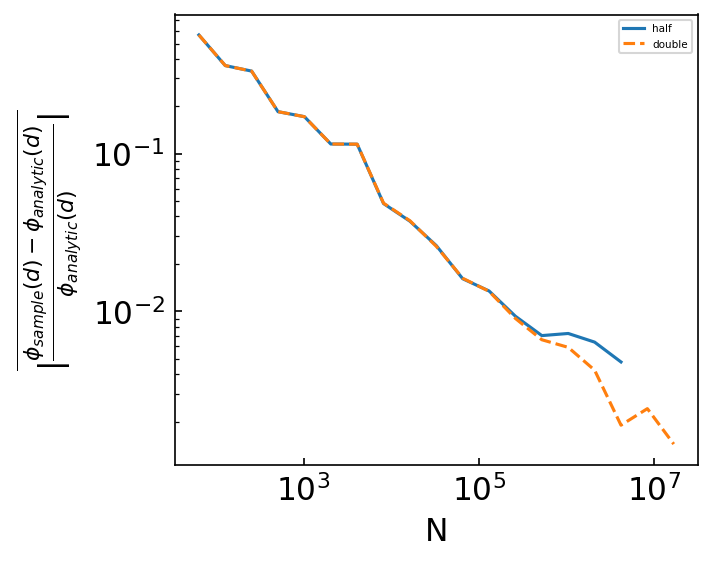

In [33]:
plt.plot(ns,ys1,label="half")
plt.plot(ns,ys2,'--',label="double")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("N")
plt.ylabel(r"$\overline{|\frac{\phi_{sample}(d) - \phi_{analytic}(d)}{\phi_{analytic}(d)}|}$")
plt.legend()
plt.tight_layout()
plt.show()

[0.003961810360816942, 0.0018661514926766338, 0.0013040759935651208, 0.0042235403163205, 0.0038181402458896934, 0.00469338140914246, 0.0032235734068193967, 0.007420291788864846, 0.02348873931657356, 0.0131168212279676, 0.017215378982967704, inf, inf, inf, inf, inf, inf, inf, inf]


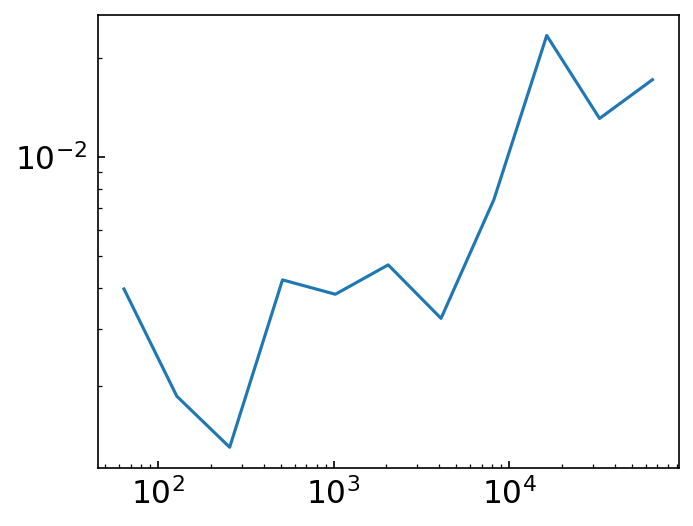

In [8]:
print(ys)
sim.pretty_plots.plot_pretty()
plt.plot(ns,ys)
plt.xscale('log')
plt.yscale('log')
plt.show()